In [36]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append("../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import torch
import torchvision as tv
from finetune import finetune_resnet, get_all_predictions_and_labels
from get_datasets import get_gz2
import random
from ppi import clt_iid
from scipy.stats import norm
from tqdm import tqdm
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [5]:
# Directories
data_dir = './data/gz2/'#'~/../../checkpoints/aa/galaxy-zoo-data/gz2'
os.makedirs(data_dir, exist_ok=True)
save_dir = '../../../../../checkpoints/aa/galaxy-zoo-data/gz2-models'
os.makedirs(save_dir, exist_ok=True)

In [6]:
datasets = get_gz2(data_dir, download=False)

In [7]:
frac_spiral = np.array([datasets['test'][np.random.choice(len(datasets['test']))][1] for idx in range(1000)]).mean()
print(frac_spiral)

0.277


In [9]:
num_classes = 2
batch_size = 32
num_epochs = 20
feature_extract = False
num_workers = 0
model = finetune_resnet(
        datasets,
        save_dir,
        num_classes,
        batch_size,
        num_epochs,
        feature_extract,
        num_workers
    )
model = model.eval()

In [16]:
preds, labels = get_all_predictions_and_labels(model, datasets['val'], batch_size, num_workers, save_dir)

In [22]:
n = 1000
N = preds.shape[0] - n
alpha = 0.1

true_theta = labels.mean()

In [28]:
# Problem setup
ns = np.array([50,100,200,300,500,750,1000])
total_N = preds.shape[0]
num_trials = 100
alpha = 0.1
true_mean = labels.mean()
C_imputed = clt_iid(preds, alpha)


# Monte Carlo 
lengths = np.zeros((ns.shape[0],num_trials,2))
lower_endpoints = np.zeros((ns.shape[0],num_trials,2))
upper_endpoints = np.zeros((ns.shape[0],num_trials,2))
covereds = np.zeros((ns.shape[0],num_trials,2))
for j in tqdm(range(ns.shape[0])):
    for i in range(num_trials):
        n = ns[j]
        N = total_N - n
        idx_rand = np.random.permutation(preds.shape[0])
        preds_labeled, preds_unlabeled = preds[idx_rand[:n]], preds[idx_rand[n:]]
        labels_labeled, labels_unlabeled = labels[idx_rand[:n]], labels[idx_rand[n:]]

        classical = clt_iid(labels_labeled, alpha)
        lower_endpoints[j,i,1], upper_endpoints[j,i,1] = classical[0], classical[1]

        rechat = (labels_labeled - preds_labeled).mean()
        sigma_rec = (labels_labeled - preds_labeled).std()
        theta_f = preds_unlabeled.mean()
        sigma_f = preds_unlabeled.std()
        w = norm.ppf(1-alpha)*np.sqrt( (sigma_rec**2)/n + (sigma_f**2)/N )
        prediction_powered = [theta_f + rechat - w, theta_f + rechat + w]
        lower_endpoints[j,i,0], upper_endpoints[j,i,0] = prediction_powered[0], prediction_powered[1]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.76it/s]


In [31]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

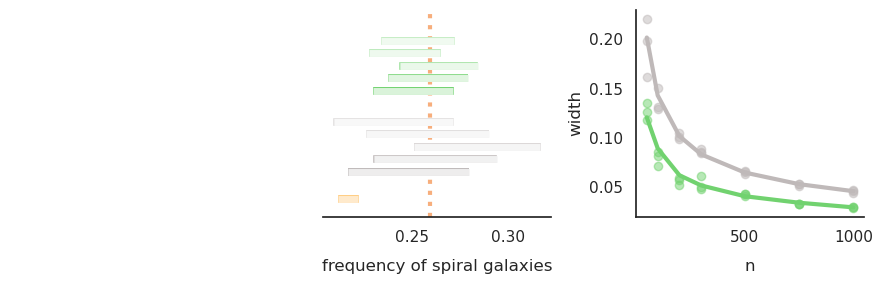

In [54]:
# Make plot
n_idx = 4
num_intervals = 5

pp_intervals = []
classical_intervals = []
for i in range(num_intervals):
    trial_idx = np.random.choice(num_trials)
    
    pp_intervals += [
        [lower_endpoints[n_idx,trial_idx,0], upper_endpoints[n_idx,trial_idx,0]]
    ]
    
    classical_intervals += [
        [lower_endpoints[n_idx,trial_idx,1], upper_endpoints[n_idx,trial_idx,1]]
    ]

xlim = [None, None]
ylim = [0,1.15]
linewidth = 5
linewidth_modifier = 1.1
offset = 0.25
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(9,3))
sns.set_theme(style="white", font_scale=1, font="DejaVu Sans")
axs[1].axvline(true_mean, ymin=0.0, ymax=1, linestyle="dotted", linewidth=3, label="frequency of spiral galaxies", color="#F7AE7C")

for i in reversed(range(num_intervals)):
    pp_interval = pp_intervals[i]
    classical_interval = classical_intervals[i]
    
    if i == 0:
        axs[1].plot([pp_interval[0], pp_interval[1]],[0.7, 0.7], linewidth=linewidth, color="#DAF3DA", path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground="#71D26F"), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground="#71D26F"), pe.Normal()], label=' prediction-powered', solid_capstyle="butt")
        axs[1].plot([classical_interval[0], classical_interval[1]],[0.25,0.25], linewidth=linewidth, color="#EEEDED", path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground="#BFB9B9"), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground="#BFB9B9"), pe.Normal()], label=' classical', solid_capstyle="butt")
        axs[1].plot([C_imputed[0], C_imputed[1]],[0.1, 0.1], linewidth=linewidth, color="#FFEACC", path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground="#FFCD82"), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground="#FFCD82"), pe.Normal()], label=' imputed', solid_capstyle="butt")
    else:
        lighten_factor = 0.8/np.sqrt(i)
        yshift = i*0.07
        axs[1].plot([pp_interval[0], pp_interval[1]],[0.7 + yshift, 0.7 + yshift], linewidth=linewidth, color=lighten_color("#DAF3DA", lighten_factor), path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground=lighten_color("#71D26F", lighten_factor)), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground=lighten_color("#71D26F", lighten_factor)), pe.Normal()], solid_capstyle="butt")
        axs[1].plot([classical_interval[0], classical_interval[1]],[0.25 + yshift,0.25 + yshift], linewidth=linewidth, color=lighten_color("#EEEDED", lighten_factor), path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground=lighten_color("#BFB9B9", lighten_factor)), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground=lighten_color("#BFB9B9", lighten_factor)), pe.Normal()], solid_capstyle="butt")


axs[1].set_xlabel("frequency of spiral galaxies", labelpad=10)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_ylim(ylim)
axs[1].set_xlim(xlim)

sns.despine(ax=axs[1],top=True,right=True,left=True)

axs[2].plot(ns, upper_endpoints.mean(axis=1)[:,0]-lower_endpoints.mean(axis=1)[:,0], label="prediction-powered", color="#71D26F", linewidth=3)
num_scatter = 3
rand_idx_scatter = [np.random.choice(num_trials, size=num_scatter).astype(int) for n in ns]

scatter_xs = np.concatenate([np.concatenate([[ns[j]] * num_trials])[rand_idx_scatter[j]] for j in range(ns.shape[0])])
scatter_ys = np.concatenate([upper_endpoints[j,:,0][rand_idx_scatter[j]].flatten() - lower_endpoints[j,:,0][rand_idx_scatter[j]].flatten() for j in range(ns.shape[0])])
axs[2].scatter(
    scatter_xs,
    scatter_ys,
    color="#71D26F",
    alpha=0.5
)
    
axs[2].plot(ns, upper_endpoints.mean(axis=1)[:,1]-lower_endpoints.mean(axis=1)[:,1], label="classical", color="#BFB9B9", linewidth=3)
scatter_xs = np.concatenate([np.concatenate([[ns[j]] * num_trials])[rand_idx_scatter[j]] for j in range(ns.shape[0])])
scatter_ys = np.concatenate([upper_endpoints[j,:,1][rand_idx_scatter[j]].flatten() - lower_endpoints[j,:,1][rand_idx_scatter[j]].flatten() for j in range(ns.shape[0])])
axs[2].scatter(
    scatter_xs,
    scatter_ys,
    color="#BFB9B9",
    alpha=0.5
)

axs[2].locator_params(axis='y', tight=None, nbins=6)
axs[2].set_ylabel("width")
axs[2].set_xlabel("n",  labelpad=10)
sns.despine(ax=axs[2],top=True, right=True)

sns.despine(ax=axs[0],top=True, right=True, left=True, bottom=True)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])

plt.tight_layout()
plt.savefig('./allplots.pdf')

1
tensor([[0.1551, 0.8449]], grad_fn=<SoftmaxBackward0>)


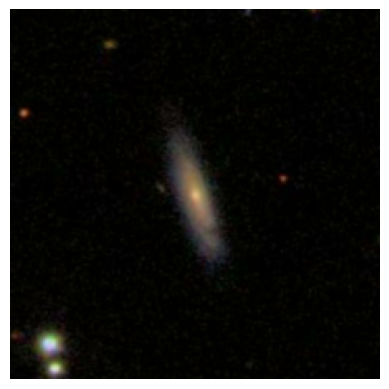

In [44]:
dataset_name = 'test'
model = model.cpu()
sample_idx = np.random.choice(len(datasets[dataset_name]))
print(datasets[dataset_name][sample_idx][1])
print(model(datasets[dataset_name][sample_idx][0][None,:,:,:]).softmax(dim=1))
plt.imshow((datasets[dataset_name][sample_idx][0].permute(1,2,0) * torch.tensor([0.0885, 0.0742, 0.0629])[None,None,:]) + torch.tensor([0.0419, 0.0406, 0.0244])[None,None,:])
plt.axis('off');